In [1]:
using Revise
using SourceSeparationNF
using MLDatasets
using LinearAlgebra
using ProgressMeter
using Statistics
using PyPlot

BLAS.set_num_threads(1)

┌ Info: Precompiling SourceSeparationNF [0967cf83-991d-4407-9a5d-c519cfeee958]
└ @ Base loading.jl:1423


In [2]:
# fetch data
train_x, train_y = MNIST.traindata(dir = "../data/MNIST");

In [3]:
function create_neural_network(dim; optimizer::Type{<:AbstractOptimizer}=Adam)

    return Model(dim,
        (
            DenseLayer(dim, 8; optimizer=optimizer),
            ReluLayer(8),
            DenseLayer(8, 8; optimizer=optimizer),
            ReluLayer(8),
            DenseLayer(8, dim; optimizer=optimizer)
        )
    )

end

create_neural_network (generic function with 1 method)

In [4]:
model = Model(
    28*28,
    10,
    (
        MvAdditiveLayer(28*28, create_neural_network(28*14)),
        PermutationLayer(28*28),
        MvAdditiveLayer(28*28, create_neural_network(28*14)),
        DenseLayer(28*28, 10),
        SoftmaxLayer(10)
    )
);

In [5]:
setlr!(model, 1e-3)
setbatchsize!(model, 64)

In [6]:
# allocate for input image
input = Matrix{Float64}(undef, 28, 28)
output = Vector{Float64}(undef, 10)
loss_function = CCE();

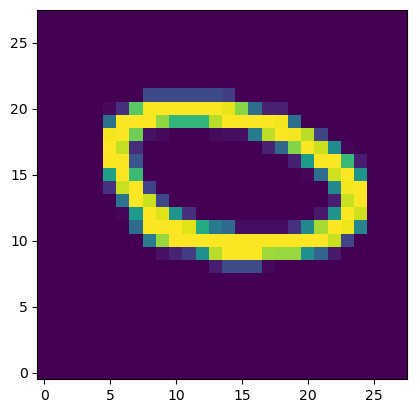

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\s151781\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


10-element Vector{Float64}:
 0.07665924037718651
 0.10086878841776895
 0.0644075453817804
 0.12206304845842195
 0.1076178079245853
 0.082538082677383
 0.11807268036075376
 0.06819368180163089
 0.09016693104068127
 0.169412193559808

In [7]:
# show initial prediction
using StatsFuns: softmax
input = convert(Matrix{Float64}, train_x[:,:,1001])
plt.imshow(input, origin="lower")
softmax(forward!(model, vec(input)))

In [8]:
loss = Vector{Float64}(undef, 60_000)
@showprogress for epoch in 1:50
    for k in 1:60_000
        # load data
        input .= train_x[:,:,k]
        output .= 0.0
        output[train_y[k]+1] = 1.0

        # train model
        loss[k] = train!(model, vec(input), output, loss_function)
    end
    println("epoch ", lpad(epoch, 3, "0"), ": ", mean(loss))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:13


epoch 001: 0.04272083464417228
epoch 002: 0.023740168055486885
epoch 003: 0.01989278294070811
epoch 004: 0.01745787550165145
epoch 005: 0.015898527393436845
epoch 006: 0.014668521553204156
epoch 007: 0.013820336171185655
epoch 008: 0.013058077194754814
epoch 009: 0.012464929247828351
epoch 010: 0.011945956969840061
epoch 011: 0.011557046789686698
epoch 012: 0.011148751912569518
epoch 013: 0.010851363845825066
epoch 014: 0.010544556645038483
epoch 015: 0.01028909532027023
epoch 016: 0.010048985621437278
epoch 017: 0.009849906676032989
epoch 018: 0.009584354191267698
epoch 019: 0.009496620402518821
epoch 020: 0.009228814308324163
epoch 021: 0.009073082470601726
epoch 022: 0.00889979214827751
epoch 023: 0.00880412120124575
epoch 024: 0.008617213871585821
epoch 025: 0.008506608800290614
epoch 026: 0.008348763203874699
epoch 027: 0.008196627071570579
epoch 028: 0.008115574984199202
epoch 029: 0.008018390693302829
epoch 030: 0.00788141619866012
epoch 031: 0.007817656916735704
epoch 032: 0.00

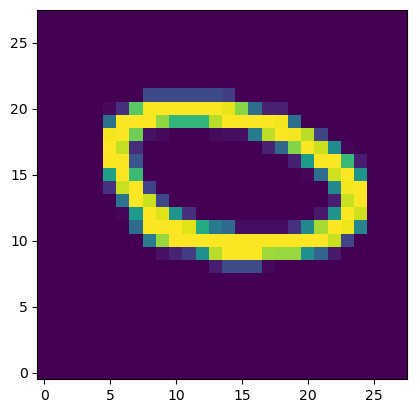

10-element Vector{Float64}:
 0.9998193916362278
 1.1203591720522619e-11
 7.245263738004686e-6
 2.583816439677338e-6
 3.959167984592527e-11
 9.740720017884691e-5
 1.5933434867276583e-5
 4.351970075981649e-7
 5.056266131170063e-5
 6.440739433990008e-6

In [9]:
# show final prediction
using StatsFuns: softmax
input = convert(Matrix{Float64}, train_x[:,:,1001])
plt.imshow(input, origin="lower")
softmax(forward!(model, vec(input)))